## Import

In [4]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import mobilenet_v3_small
import torch.optim as optim

## Download CIFAR-10 Dataset

In [ ]:
# Check if CIFAR-10 dataset is downloaded

transform = transforms.Compose([
    # CIFAR-10 images are 32x32; MobileNet needs 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=4)

## Preview dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.656061..2.0781739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9100897..1.3695536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.317046..1.6594436].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7671986..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9735969..2.011479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..

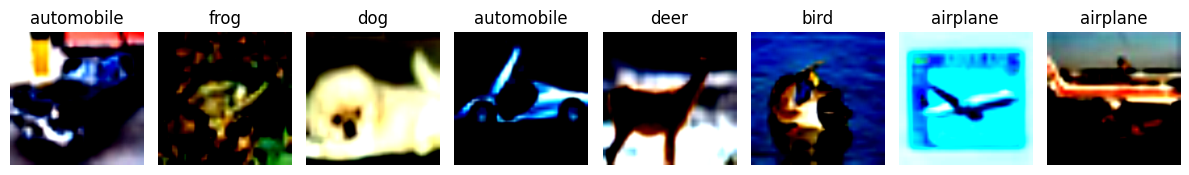

In [ ]:

# Class labels for CIFAR-10
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = train_dataset.classes

# Grab a batch
images, labels = next(iter(train_loader))

# Convert from tensors to numpy for plotting


def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')


# Plot images in a row
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()


## Load the network: MobileNetV3-Small

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = mobilenet_v3_small(pretrained=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 10)  # CIFAR-10 = 10 classes
model = model.to(device)

Using device: cpu


c:\Users\andpo\Documents\AIToolsProject\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andpo\Documents\AIToolsProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [ ]:
n_epochs = 10  # Number of epochs
for epoch in range(n_epochs):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


## Evaluation

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100. * correct / total:.2f}%")

### Confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [5]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

PyTorch version: 2.6.0+cpu
CUDA available: False
CUDA device count: 0
CUDA device name: N/A
